In [1]:
#Py4DSTEM: 28296e8d515578b4e86081d67b38fbc45f1a10ca (commented shift_regularisation)
#abtem: 4d630003af7a2d33ee63e9a02f1846549d04be00
import os
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *

import scipy.constants as c
from abtem.reconstruct import invms

from abtem.custom import semiangle_2_sampling_extent,semiangle_gpts_2_extent
from abtem.scan import PositionScan

import cupy as cp
import h5py
import pathlib

import matplotlib
from abtem.custom import incoherent_probe, get_probe_radius
from ase.build import nanotube
from abtem.custom import crop
from abtem.noise import poisson_noise
from abtem.custom import decimate_measurement



In [3]:
def get_positions(scan_gpts,extent,scan_sampling):
    scan_start = extent/2-scan_sampling*(scan_gpts-1)/2
    scan_end = scan_start+scan_sampling*(scan_gpts) # although wrong it works so that extent/2 is where cetnral scan is. 
    scan_grid = GridScan(scan_start, scan_end, sampling = scan_sampling)
    positions = scan_grid.get_positions()
    return(positions)


In [4]:
def get_potential_from_atoms(atoms_in, extent, sampling):
    atoms=atoms_in.copy()
    vacuum_offset=0
    atoms.center(vacuum=0)
    atoms_extent=atoms.cell.diagonal() #x,y,z
    
    vacuum=(extent-atoms_extent)/2 #x,y,z
    atoms.center(vacuum=vacuum[0]+vacuum_offset,axis=(0))
    atoms.center(vacuum=vacuum[1]+vacuum_offset,axis=(1))

    atoms.center(vacuum=2,axis=(2))

    potential = Potential(FrozenPhonons(atoms, sigmas=0.06, num_configs=1), #atoms_p,
                      sampling=sampling,
                      slice_thickness=2,
                      projection='infinite',
                      parametrization='kirkland')
    return(atoms,potential)

In [5]:
energy = 22e3
px_size = 56e-6
px_num = 256
camera_length = 240e-3
angular_sampling = px_size/camera_length*1e3 # in mrad
angular_semiextent = angular_sampling * px_num / 2
                                                                                                                                                                                                                                                                                                                               
binning = 1
reciprocal_oversampling = 1
direct_oversampling = 4
sampling,extent = semiangle_2_sampling_extent(angular_semiextent,px_num/binning,energy=energy,direct_oversampling=direct_oversampling,reciprocal_oversampling=reciprocal_oversampling)

In [206]:
semiangle_cutoff = 15 # 15 # nebo 10 mrad a 3000 A defocus
defocus=2000 # 0 nebo 2000
aberrations={"C30":0.88e-3/1e-10,'C50':0*0.81e-3/1e-10}#,"C12":1000}
#aberrations={"C30":6021062}
temporal_sigma=0
spatial_sigma=0

probe = Probe(energy=energy, defocus=defocus, semiangle_cutoff=semiangle_cutoff,rolloff=2, **aberrations, device="gpu",sampling=sampling,extent=extent)

In [207]:
from abtem.transfer import scherzer_defocus

In [208]:
scherzer_defocus(aberrations['C30'],energy)

1039.1770751911145

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fec04163f10>)

<Figure size 2000x2000 with 0 Axes>

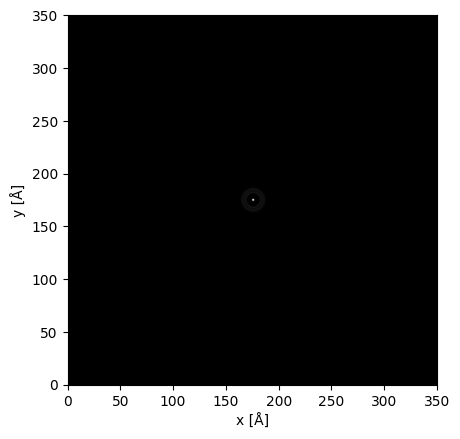

In [209]:
plt.figure(figsize=(20,20))
probe.show(power=2)

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

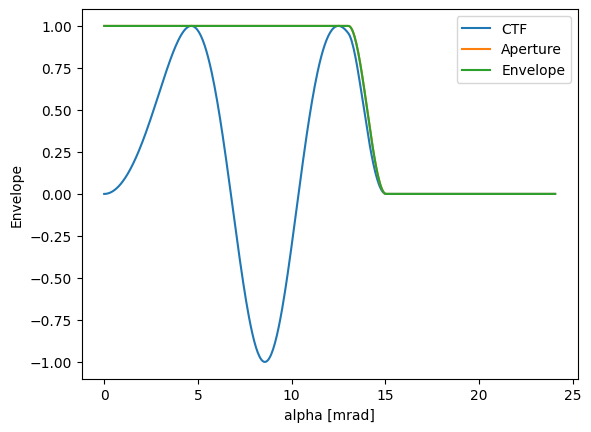

In [210]:
probe.ctf.show()

In [211]:
detector = PixelatedDetector(None)

In [212]:
from ase import Atoms

In [213]:
12e-3*1/probe.wavelength

0.14668174315911953

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

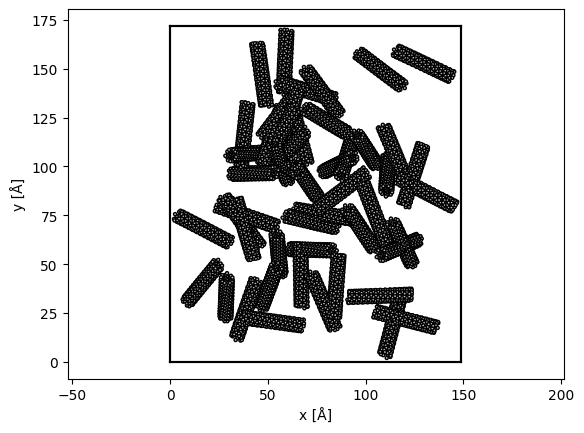

In [214]:
N=50*reciprocal_oversampling**2
np.random.seed(2)
#cnt_positions=np.random.uniform(-80,80,(N,2))
cnt_positions=(np.random.beta(2.5,2.5,(N,2))-1)*2*80*reciprocal_oversampling
#cnt_positions[:,0]*=np.random.uniform(0,0.1,N)
cnt_rotations_y=np.random.uniform(-60,+60,N)
cnt_rotations_z=np.random.uniform(0,360,N)

atoms=Atoms()
for i in range(N):
    cnt = nanotube(5, 4, length=1)
    cnt.rotate(90+cnt_rotations_y[i],"y",center='COM')
    cnt.rotate(cnt_rotations_z[i],"z",center='COM')
    cnt.center(vacuum=1,about=0)
    cnt.translate(np.array([*cnt_positions[i],0]))
    atoms += cnt
atoms.center(vacuum=2)
atoms.set_chemical_symbols(["Ti" for i in range(len(atoms))])
show_atoms(atoms,plane="xy")

In [215]:
_,potential=get_potential_from_atoms(atoms, extent, sampling);

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febf6bbcf40>)

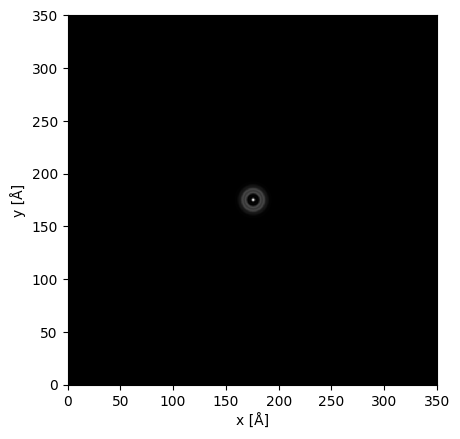

In [216]:
probe.show()

In [259]:
incoh_probe=incoherent_probe(probe,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)                                                                                                                                                                                                                            
r, _, _, _= get_probe_radius(probe_measurement=incoh_probe,current_ratio=0.90)                                                                                                                                                                                                                                             
d=2*r
scan_extent = potential.extent[0]*4/6
scan_gpts = 32
#scan_sampling = scan_extent/scan_gpts
scan_sampling = d*0.15/2*2#*np.random.uniform(0.15,0.5)# 2 angstrom?
positions=get_positions(scan_gpts,np.array(probe.extent),scan_sampling)                                                                                                                                                                                                                                                  
scan=PositionScan(positions=positions)

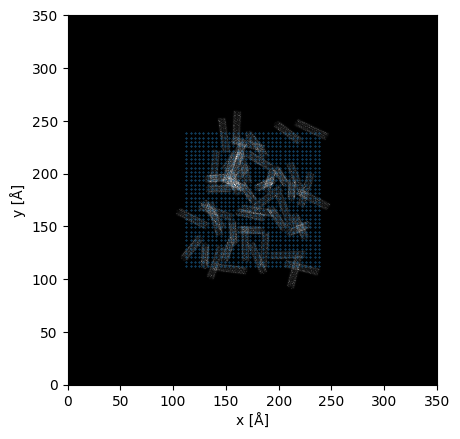

In [260]:
potential.build().project().show()
plt.plot(positions[:,0],positions[:,1],"x",markersize=1,alpha=0.5)

In [261]:
scan_sampling

4.049296426940103

In [262]:
measurement_raw=probe.scan(scan,detectors=detector,potential=potential,max_batch=50,pbar=False)                                                                                                                                                                                                                       

measurement_=crop(measurement_raw,extent=(angular_semiextent*2+1e-4,angular_semiextent*2+1e-4))# TODO!!!
#measurement_=crop(measurement_raw,extent=(angular_semiextent*2,angular_semiextent*2))# TODO!!!

measurement_ = decimate_measurement(measurement_,reciprocal_oversampling)                                                                                                     
#measurement_ = decimate_measurement(measurement_,2)

In [263]:
measurement_.shape

(1024, 256, 256)

In [264]:
norm=np.mean(np.sum(measurement_raw.array,(-2,-1))) # !uncropped! 
el=50e-12*1e-3/c.e 
measurement = poisson_noise(measurement_/norm, dose=el,pixel_area=1)/el 

(<Axes: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7febf6501420>)

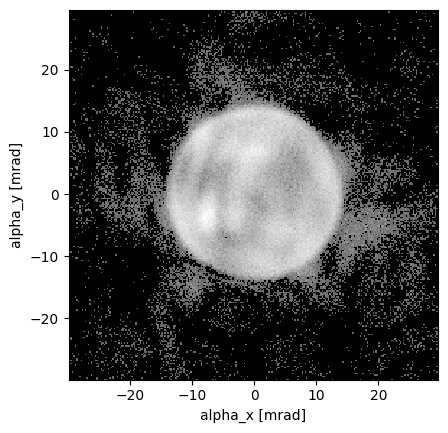

In [265]:
measurement[(scan_gpts//2)**2].show(power=0.2)

In [266]:
scan_sampling

4.049296426940103

In [267]:
%%time
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy,defocus=defocus,C30=aberrations['C30'],extent=40,gpts=256)
reconstructions = invms(measurement, probe_guess, positions = positions+np.random.uniform(-1,1,(len(positions),2)), modes=1,k_modes=1, alpha=0.1, fac=1, beta=0.1, slices=1, slice_thickness=21,  maxiter=2, return_iterations=True, fix_com=True,device='gpu')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

probes norm:  [0.91335448] probes norm sum:  0.9133544777685099
SSE:  2.5349397716376277e-10
probes norm:  [0.93505375] probes norm sum:  0.9350537466277198
SSE:  1.4870638041489715e-10
CPU times: user 7.15 s, sys: 129 ms, total: 7.28 s
Wall time: 7.23 s


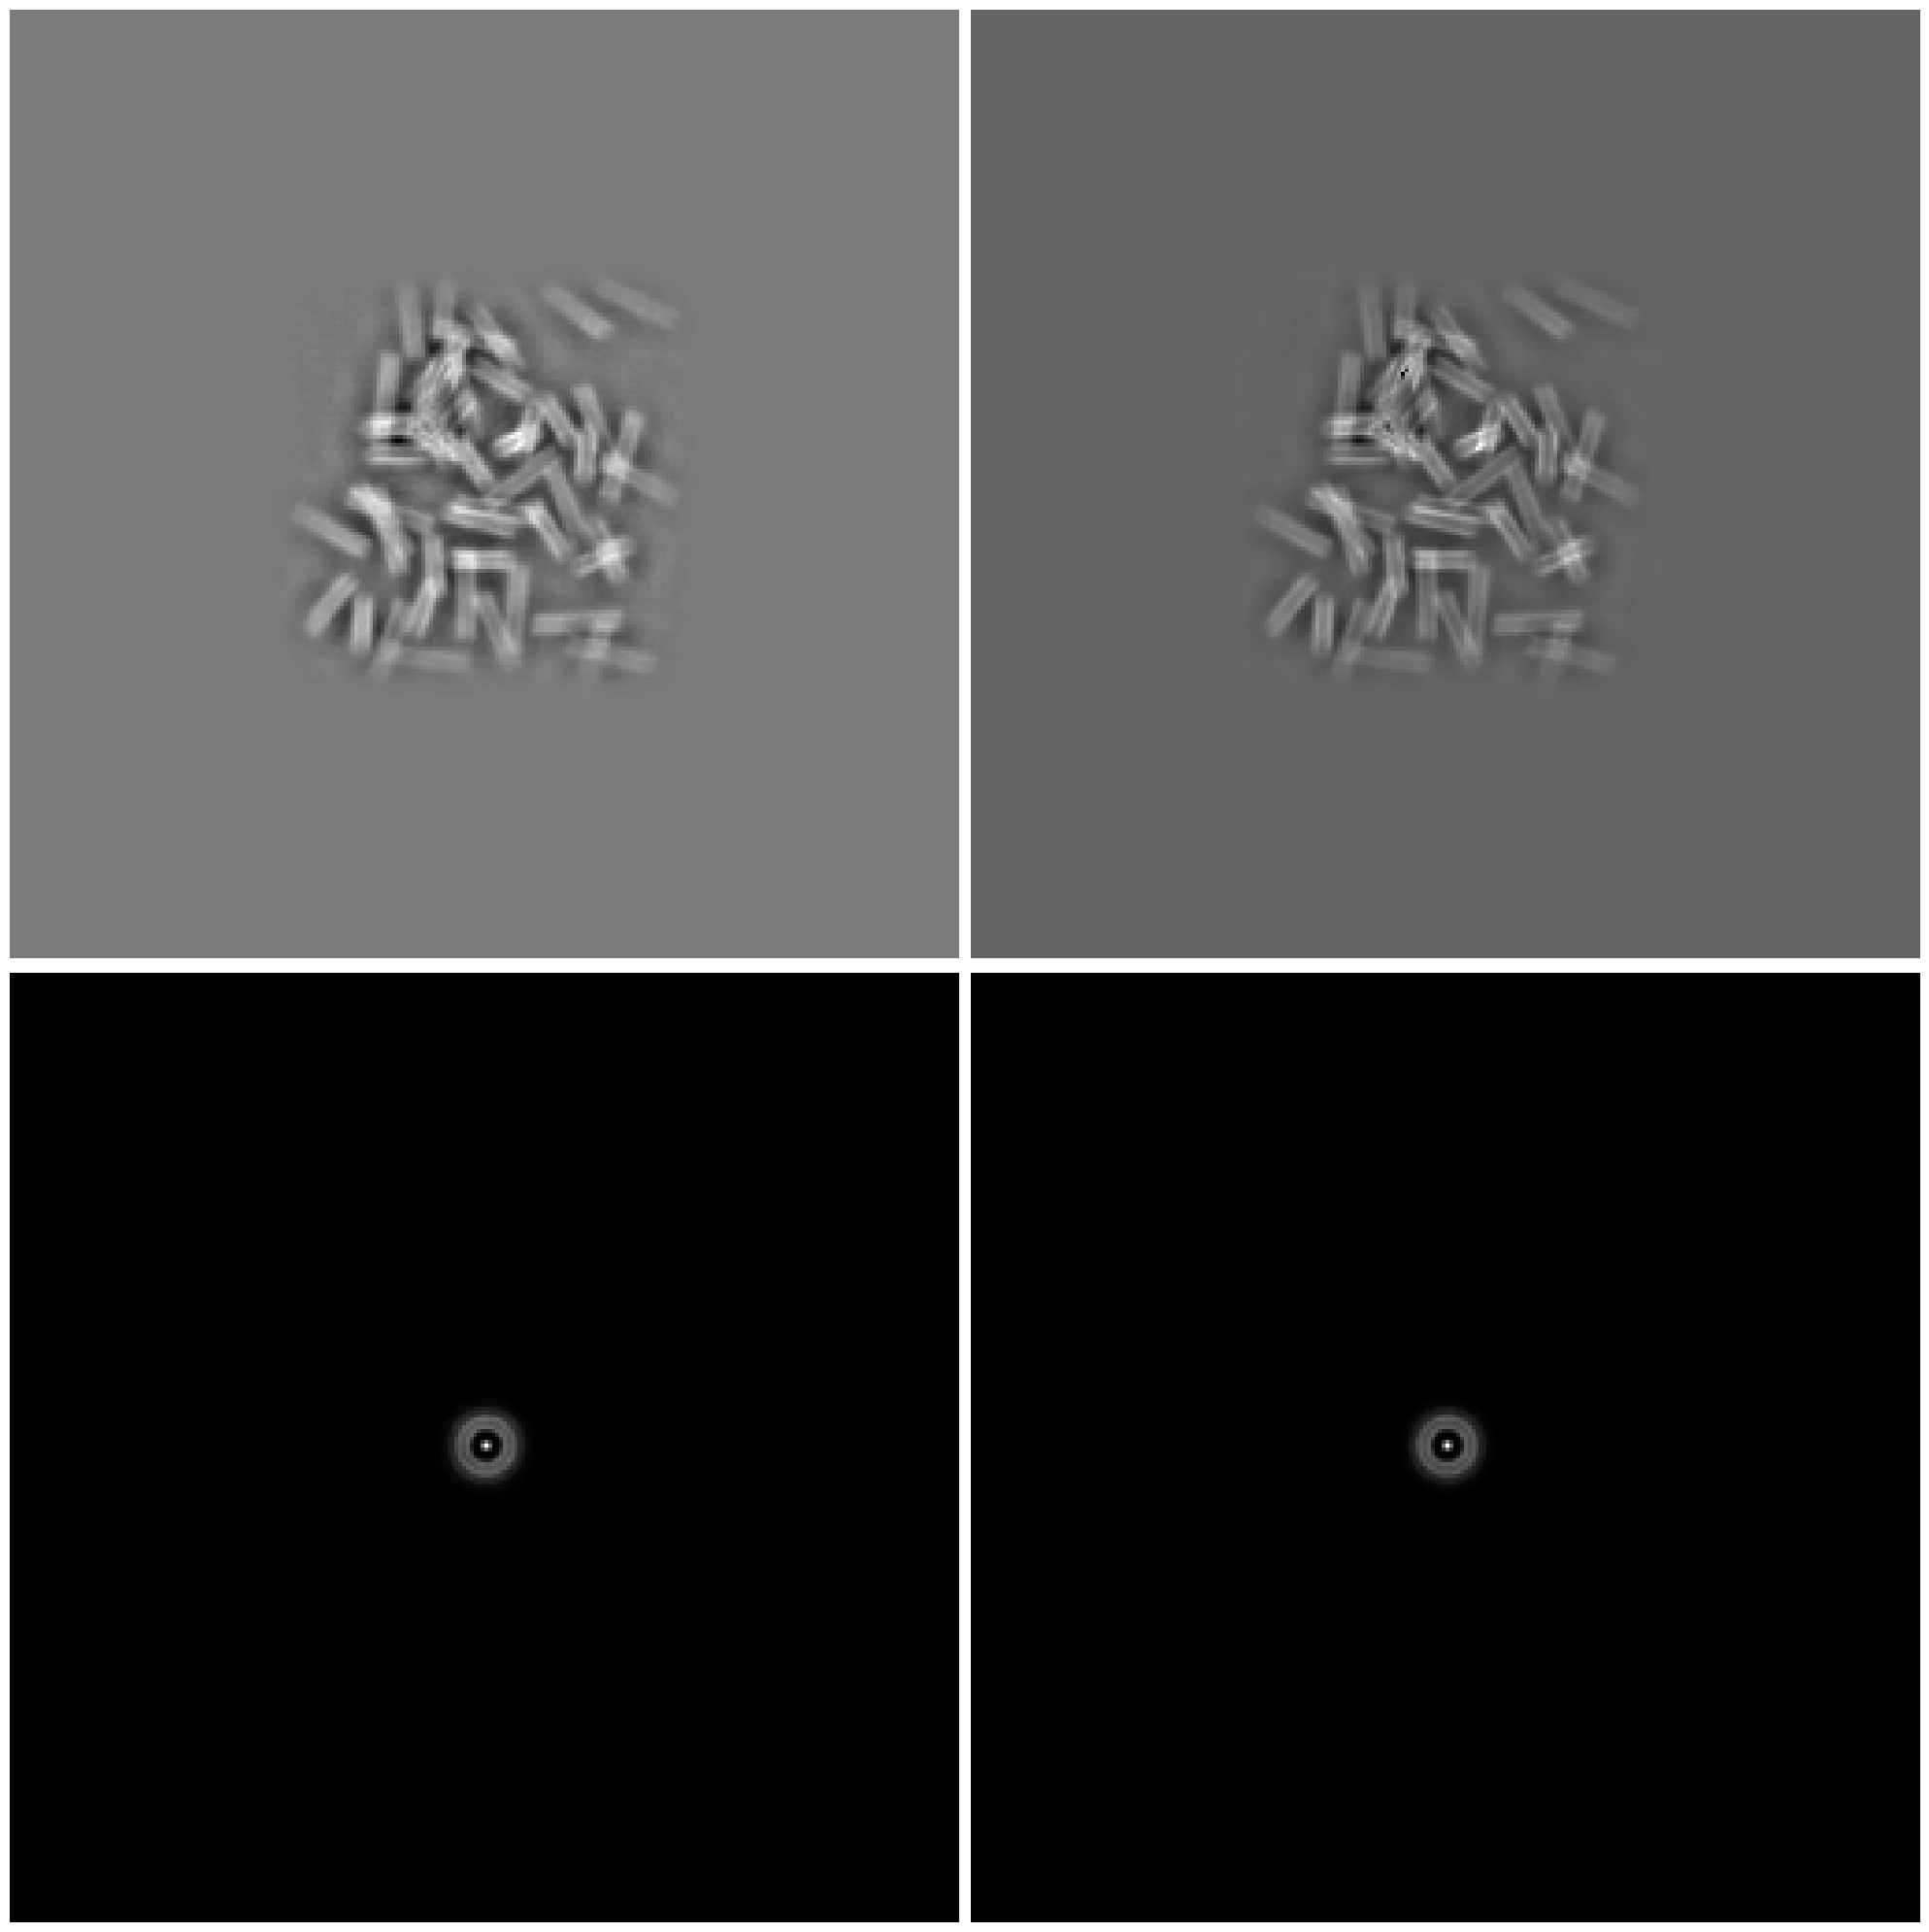

In [268]:
#%matplotlib inline
plot_every = 1

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))
for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][j][0].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

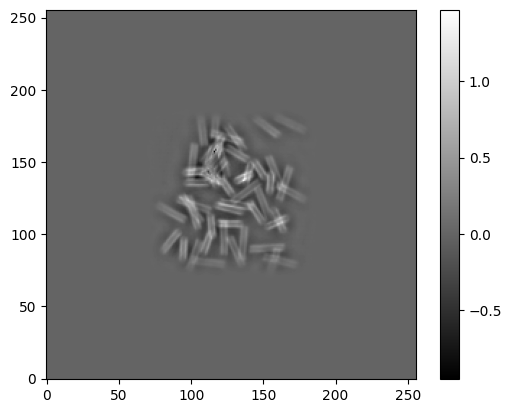

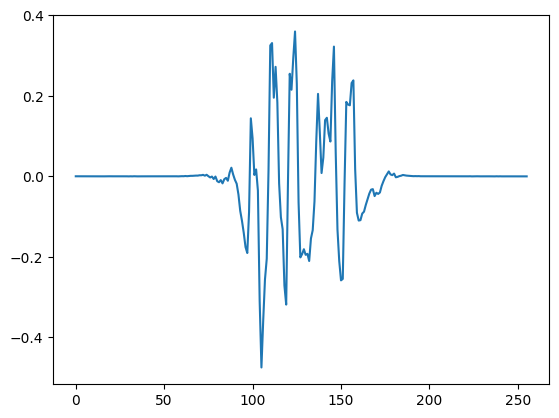

In [269]:
plt.imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
plt.colorbar()
plt.figure()
plt.plot(np.angle(reconstructions[0][j][0].array[:,150]).T)
plt.show()

In [270]:
import py4DSTEM

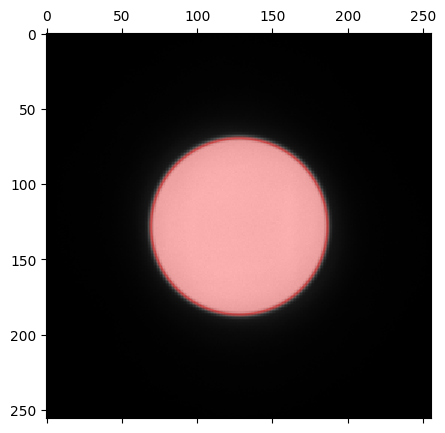

In [271]:
dataset = py4DSTEM.DataCube(measurement.array.reshape((scan_gpts,scan_gpts,*measurement.array.shape[-2:])).transpose(0,1,2,3))
dataset.get_dp_mean()
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(plot=True)

In [272]:
dataset.calibration.set_R_pixel_size(scan_sampling)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(probe.angular_sampling[0])#semiangle_cutoff / probe_radius_pixels)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.2333333333333333
             R_pixel_size:      4.049296426940103
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   58.883138310963545
             qx0_mean:          127.98101138995244
             qy0_mean:          127.91541120048673
)

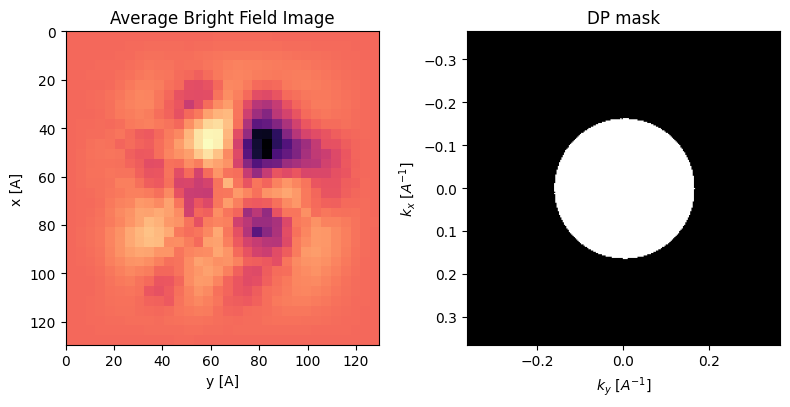

In [273]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = energy,
    object_padding_px=(32,32),
    device = "gpu",
    verbose=True,
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=16,
)

Alignment at bin 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2612/2612 [00:21<00:00, 124.29 image subsets/s]


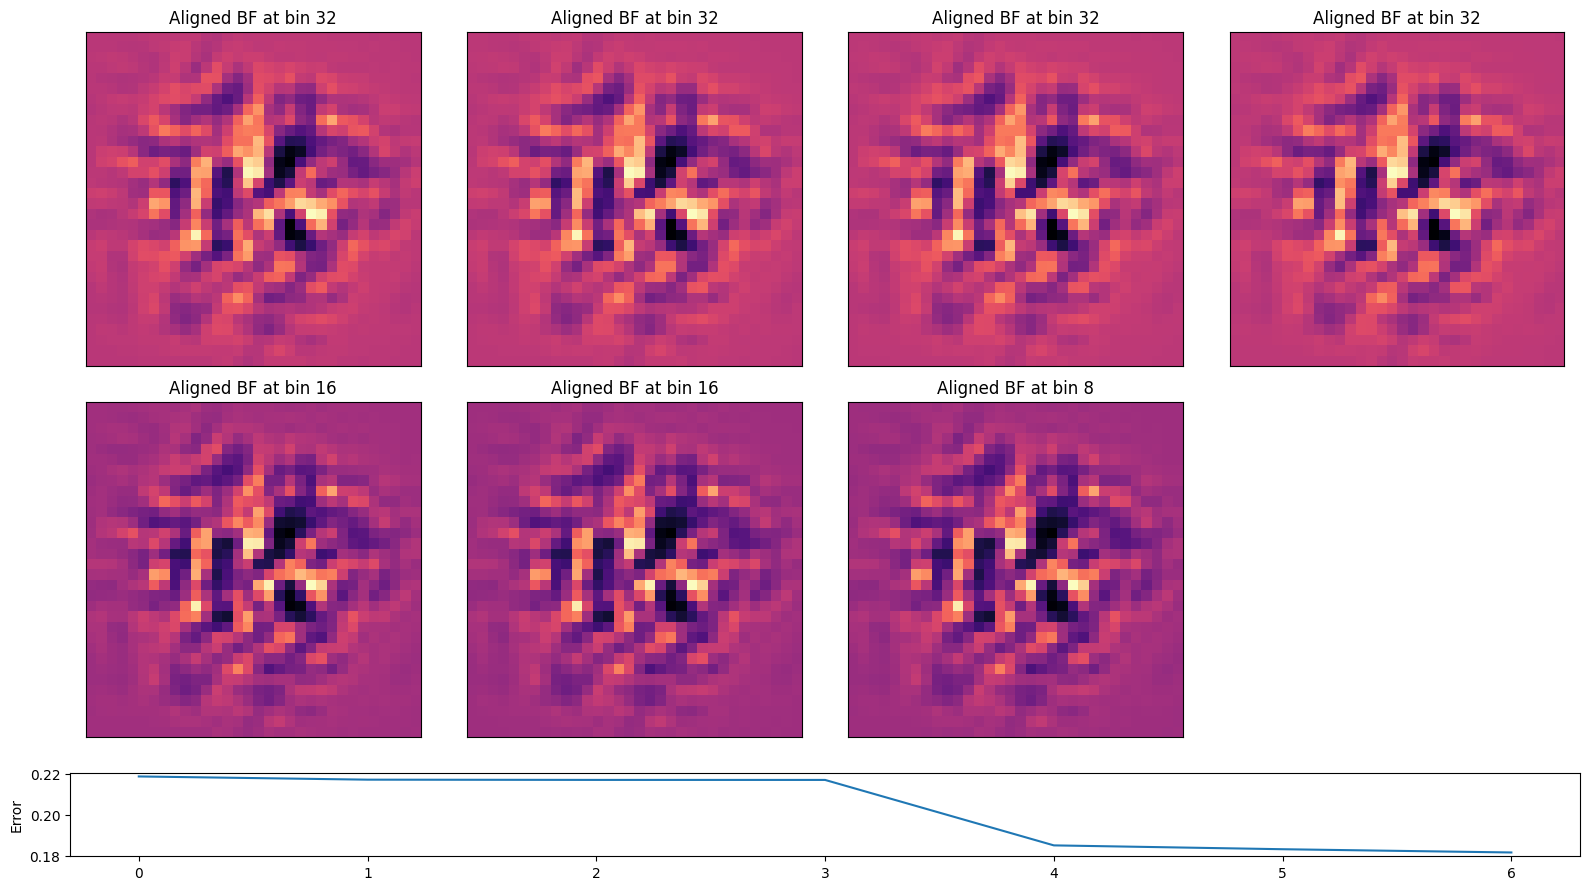

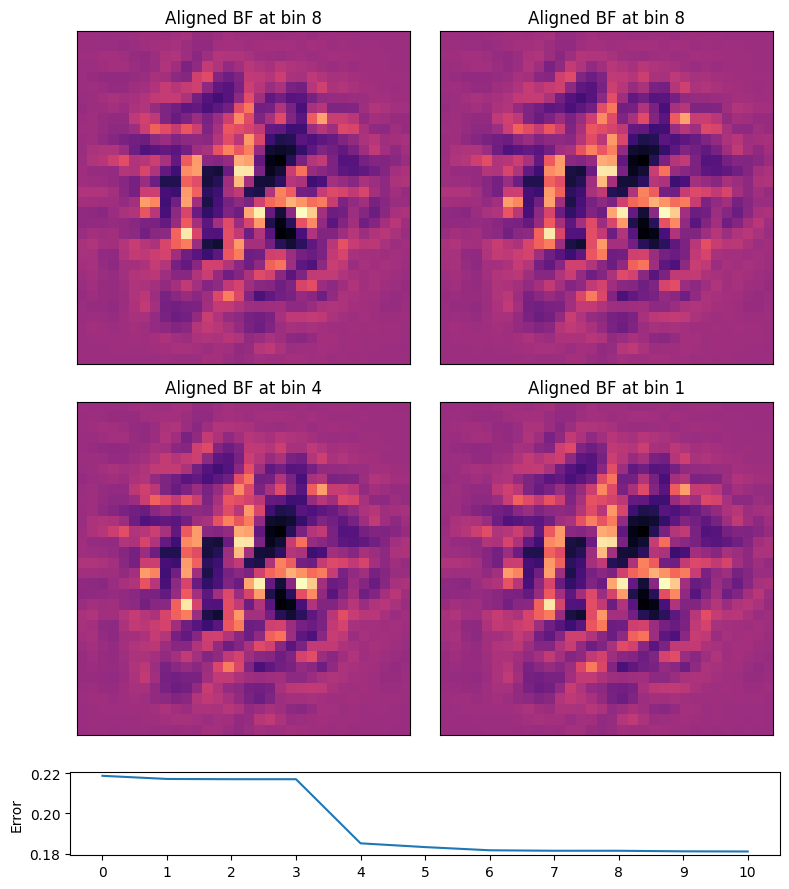

In [274]:
if 1:
    parallax = parallax.reconstruct(
        reset=True,
        regularizer_matrix_size=(16,16),
        regularize_shifts=True,
        running_average=False,
        alignment_bin_values = [32,32,32,32,16,16,8] #[32,32,16,16,8,8,8,8]#[32,32,32,32,32]
    )

    parallax = parallax.reconstruct(
        reset=False,
        #regularizer_matrix_size=(4,4),
        regularize_shifts=False,
        running_average=False,
        alignment_bin_values = [8,8,4,1] #[32,32,16,16,8,8,8,8]#[32,32,32,32,32]
    )
else: 
    parallax = parallax.reconstruct(
        reset=True,
        regularizer_matrix_size=(4,4),
        regularize_shifts=False,
        running_average=False,
        alignment_bin_values = [1]#[32,32,16,16,8,8,8,8]#[32,32,32,32,32]
    )

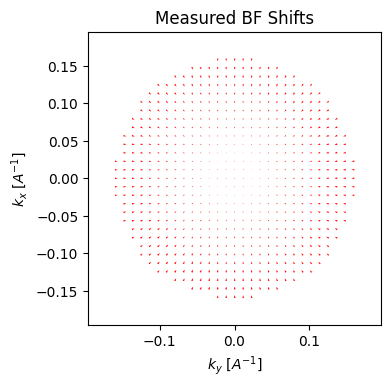

In [275]:
parallax.show_shifts(scale_arrows=0.4,plot_arrow_freq=4)

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

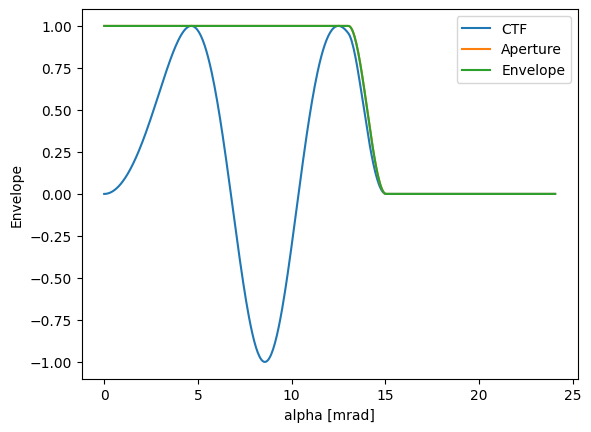

In [276]:
probe.ctf.show()

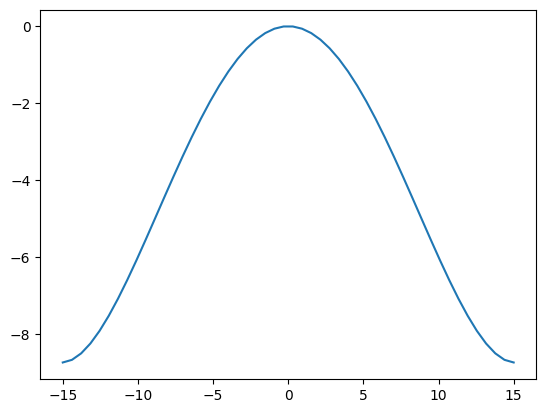

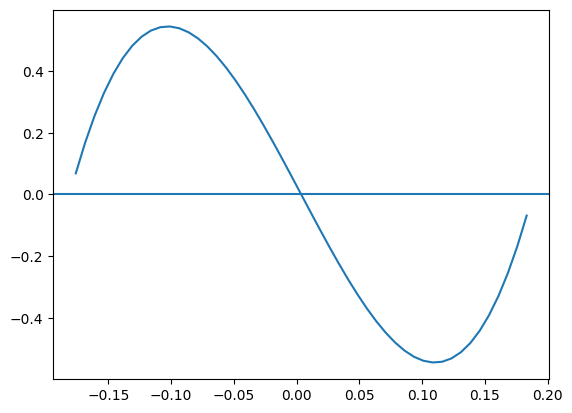

In [277]:
al=np.linspace(-semiangle_cutoff,semiangle_cutoff)
chi=probe.ctf.evaluate_chi(al*1e-3,0)
#plt.plot(al*1e-3*1/probe.wavelength,chi)
plt.plot(al,chi)
plt.figure()
plt.plot(al[1:]*1e-3*1/probe.wavelength,np.diff(chi));plt.axhline(y=0)

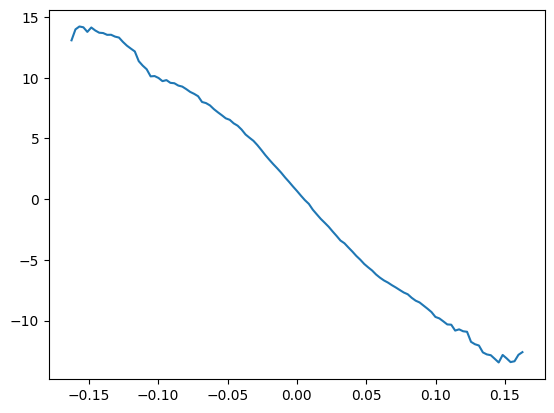

In [278]:
#plt.plot(parallax._xy_shifts[])
kx=parallax._kxy[:,0]
ky=parallax._kxy[:,1]
sel = ky==ky[np.argmin(np.abs(ky))]
kx_line = kx[sel].get()
shifts_line = scan_sampling*parallax._xy_shifts[sel,0].get()
plt.plot(kx_line,shifts_line)

In [279]:
18*1e-3*1/probe.wavelength

0.22002261473867932

In [280]:
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.2333333333333333
             R_pixel_size:      4.049296426940103
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   58.883138310963545
             qx0_mean:          127.98101138995244
             qy0_mean:          127.91541120048673
)

In [281]:
parallax._reciprocal_sampling

(0.00285214528190149, 0.00285214528190149)

Requested upsampling factor exceeds dark-field upsampling limit of 2.96.


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

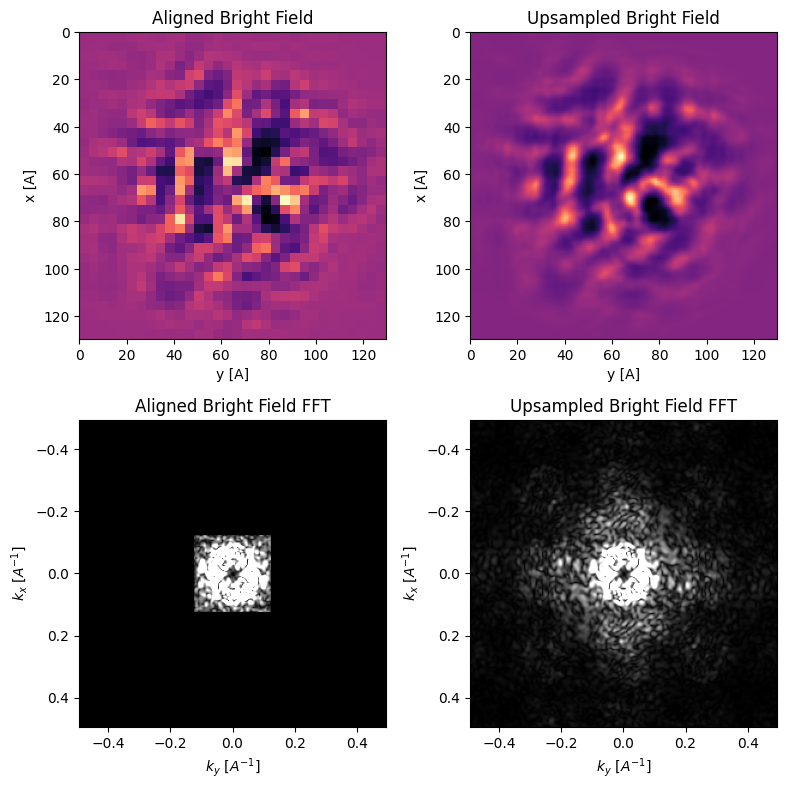

In [282]:
parallax.subpixel_alignment(
    kde_upsample_factor=4,
    kde_sigma_px=0.125,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

In [283]:
parallax._region_of_interest_shape

array([256, 256])

In [284]:
print("C30: ",aberrations["C30"])
print("defocus: ",probe.ctf.defocus)

C30:  8800000.0
defocus:  2000


Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = 0.086 deg
Astigmatism (A1x,A1y)  = (9,-7) Ang
Aberration C1          =  -1177 Ang
Defocus dF             = 1177 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -1177
stig            2        2         x      9
stig            2        2         y      -7
coma            3        1         x      4482
coma            3        1         y      -406
trefoil         3        3         x      261
trefoil         3        3         y      659


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

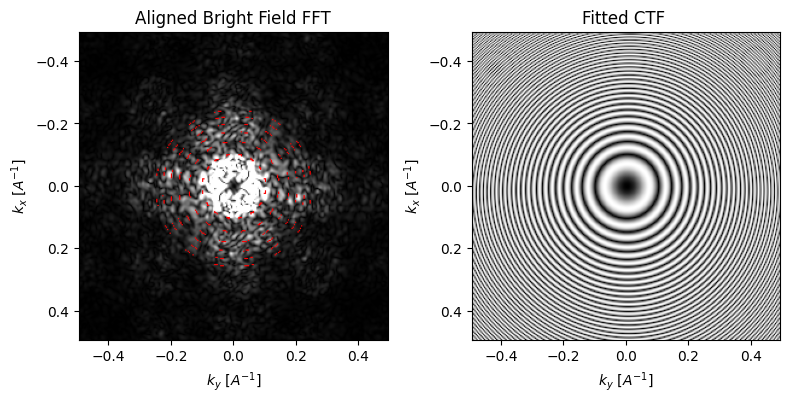

In [285]:
parallax.aberration_fit(
    #fit_CTF_FFT=True,
    fit_BF_shifts=True,
    plot_CTF_comparison=True,
    #fit_aberrations_max_radial_order=4,
    #fit_aberrations_mn=np.array([[3,0,0],[1,0,0]]),
    #fit_aberrations_mn=np.array([[3,0,0]]),
    #fit_aberrations_mn=np.array([[1,0,0]])
)

In [286]:
parallax.aberration_dict_polar

{'C10': -1176.8375472751143,
 'C12': 11.327785857622866,
 'phi12': -0.32712310632071034,
 'C21': 4500.182581899879,
 'phi21': -0.09024437846346006,
 'C23': 709.0938279027696,
 'phi23': 0.3981332192537374}

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febf64dfbb0>)

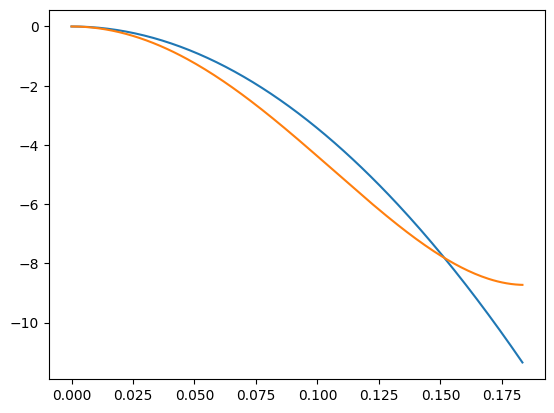

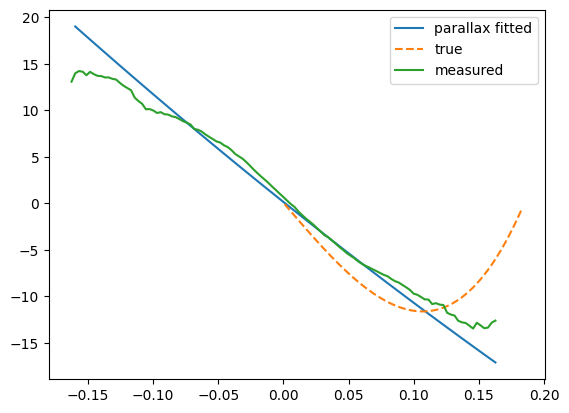

<Figure size 640x480 with 0 Axes>

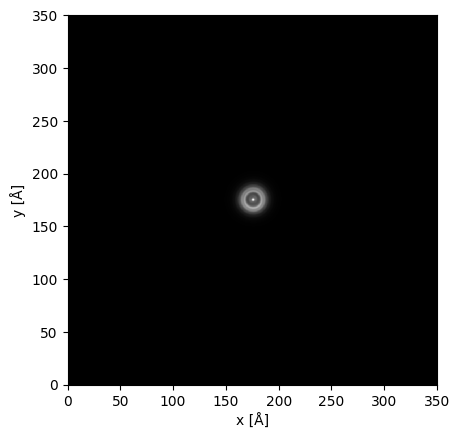

In [287]:
%matplotlib inline

probe_dummy=Probe(energy=30e3,extent=probe.extent,gpts=probe.gpts,semiangle_cutoff=semiangle_cutoff,**parallax.aberration_dict_polar) 
#probe_dummy=Probe(energy=30e3,extent=100,gpts=256,semiangle_cutoff=semiangle_cutoff,C10=2000,C30=0)

#probe_dummy.ctf.show()
alphas=np.linspace(0,semiangle_cutoff*1e-3,200)
x=alphas*1/probe.wavelength
dalpha=alphas[1]-alphas[0]
x_d=x[1:]
plt.plot(x,probe_dummy.ctf.evaluate_chi(alphas,0))
plt.plot(x,probe.ctf.evaluate_chi(alphas,0))
plt.figure()
#plt.plot(x_d,np.diff(probe_dummy.ctf.evaluate_chi(alphas,0))/dalpha/(2*np.pi/probe.wavelength),label="parallax fited")
alpha_d=(kx_line[1]-kx_line[0])/(1/probe.wavelength)
plt.plot(kx_line[1:],np.diff(probe_dummy.ctf.evaluate_chi(kx_line/(1/probe.wavelength),0))/alpha_d/(2*np.pi/probe.wavelength),label="parallax fitted")
plt.plot(x_d,np.diff(probe.ctf.evaluate_chi(alphas,0))/dalpha/(2*np.pi/probe.wavelength),"--",label="true")
plt.plot(kx_line,shifts_line,label="measured")
plt.legend()
plt.figure()
probe_dummy.show()

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7febf66e9330>)

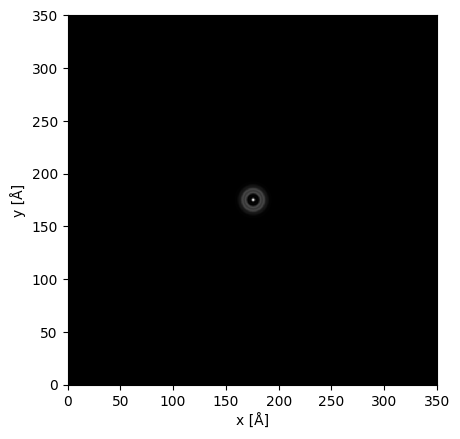

In [288]:
probe.show()

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

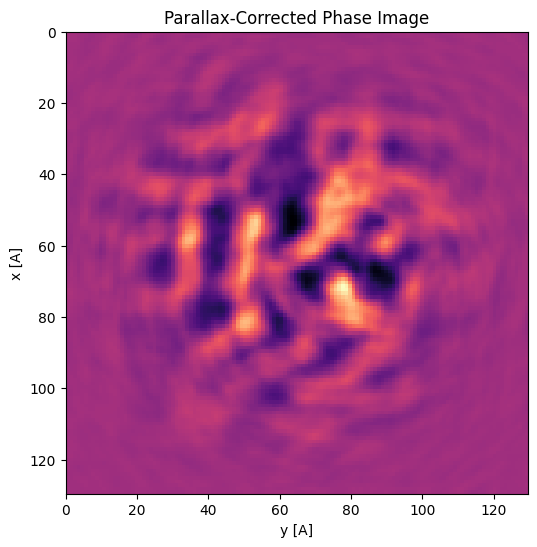

In [289]:
parallax.aberration_correct()

In [290]:
parallax.aberration_dict_polar

{'C10': -1176.8375472751143,
 'C12': 11.327785857622866,
 'phi12': -0.32712310632071034,
 'C21': 4500.182581899879,
 'phi21': -0.09024437846346006,
 'C23': 709.0938279027696,
 'phi23': 0.3981332192537374}

In [291]:
1e-3*(1/Probe(energy=80e3).wavelength)/(1/Probe(energy=30e3).wavelength)

0.0016713496441091648

In [292]:
1/(6e-3*(1/Probe(energy=300e3).wavelength)/128)

419.9997631515236

In [55]:
assert(False)
for i in np.arange(-80,80,2):
    # Position the detector
    # set the geometry by hand
    center = np.array(measurement.array.shape[-2:])//2+np.array([i,0])
    radius = 8 


    # overlay selected detector position over mean dp
    fig, axes = plt.subplots(1,2)
    dataset.position_detector(
        mode = 'circle',
        geometry = (
            center,
            radius
        ),
        figax=(fig, axes[0])
    )

    # Capture the virtual BF


    # compute
    res=dataset.get_virtual_image(
        mode = 'circle',
        geometry = (center,radius),
        #name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
    )
    
    py4DSTEM.show(res , cmap="inferno",figax=(fig,axes[1]))
    filename="figs/line_line_sph8800000_defocus2000/radius_{:02}/{:03}.pdf".format(radius,center[0])
    pathlib.Path(filename).parent.mkdir(parents=True,exist_ok=True)
    fig.savefig(filename)
    plt.close(fig)

AssertionError: 